In [20]:
import pandas as pd
import numpy as np
import os
os.getcwd()

'/Users/praveen/MSDS/MachineLearning/KaggleChallenges/Challenge2/Data'

In [21]:
train = pd.read_csv("./train_data_new.csv")
test = pd.read_csv("./test_data_new.csv")

/var/folders/h5/yfvk0l4921v0kg94n8qt42wc0000gn/T/ipykernel_64785/2922911961.py:1: DtypeWarning: Columns (31,38,40) have mixed types. Specify dtype option on import or set low_memory=False.
  train = pd.read_csv("./train_data_new.csv")


In [22]:
train = pd.read_csv("./train_data_new.csv")
test = pd.read_csv("./test_data_new.csv")
cat_vars = ['general_sector', 'city', 'zip_code', 'specific_sector', 'state',
       'contributor_type']
train_num_vars = ['winner_ratio', 'candidacy_count',
       'candidacy_democratic_count', 'candidacy_republican_count',
       'contribution_count', 'contribution_democratic_count',
       'contribution_republican_count', 'politician_challenger_count',
       'politician_count', 'politician_democratic_count',
       'politician_incumbency_count', 'politician_open_pos_count',
       'politician_republican_count', 'contribution_democratic_sum_2010_usd',
       'contribution_republican_sum_2010_usd', 'contribution_sum_2010_usd',
       'governor_contributions_sum_2010_usd',
       'house_and_assembly_contributions_sum_2010_usd',
       'senate_contributions_sum_2010_usd',
       'us_house_contributions_sum_2010_usd',
       'us_senate_contributions_sum_2010_usd', 'candidacy_democratic_ratio',
       'candidacy_republican_ratio', 'contribution_democratic_count_ratio',
       'contribution_republican_count_ratio', 'governor_contribution_ratio',
       'house_and_assembly_contribution_ratio', 'politician_challenger_ratio',
       'politician_democratic_ratio', 'politician_incumbency_ratio',
       'politician_open_pos_ratio', 'politician_republican_ratio',
       'senate_contribution_ratio', 'us_house_contribution_ratio',
       'us_senate_contribution_ratio', 'contrib_state_deg',
       'contrib_state_wdeg', 'contrib_state_pr', 'contrib_state_comm',
       'contrib_fed_deg', 'contrib_fed_wdeg', 'contrib_fed_pr',
       'contrib_fed_comm', 'state_all_deg', 'state_all_wdeg', 'state_all_pr',
       'state_all_comm', 'state_win_deg', 'state_win_wdeg', 'state_win_pr',
       'state_win_comm']
test_num_vars = [col for col in train_num_vars if col != "winner_ratio"]

train[train_num_vars] = train[train_num_vars].apply(pd.to_numeric, errors='coerce')
test[test_num_vars] = test[test_num_vars].apply(pd.to_numeric, errors='coerce')

# cols_with_negatives = ['contribution_democratic_sum_2010_usd','contribution_republican_sum_2010_usd','contribution_sum_2010_usd',
# 'governor_contributions_sum_2010_usd',
# 'house_and_assembly_contributions_sum_2010_usd','senate_contributions_sum_2010_usd','us_house_contributions_sum_2010_usd',
# 'us_senate_contributions_sum_2010_usd','governor_contribution_ratio','house_and_assembly_contribution_ratio','senate_contribution_ratio',
# 'us_house_contribution_ratio','us_senate_contribution_ratio']

# ### Treat these descrepent columns
# for col in cols_with_negatives:
#     train[col] = train[col].clip(lower=0)
#     test[col] = test[col].clip(lower=0)

import numpy as np

# 1) Define your ratio definitions (old_name, numerator, denominator)
ratio_defs = [
    # count‑based
    ("candidacy_democratic_ratio",   "candidacy_democratic_count",            "candidacy_count"),
    ("candidacy_republican_ratio",   "candidacy_republican_count",            "candidacy_count"),
    ("contribution_democratic_count_ratio","contribution_democratic_count","contribution_count"),
    ("contribution_republican_count_ratio","contribution_republican_count","contribution_count"),
    ("politician_challenger_ratio",  "politician_challenger_count",           "politician_count"),
    ("politician_democratic_ratio",  "politician_democratic_count",           "politician_count"),
    ("politician_incumbency_ratio",  "politician_incumbency_count",           "politician_count"),
    ("politician_open_pos_ratio",    "politician_open_pos_count",             "politician_count"),
    ("politician_republican_ratio",  "politician_republican_count",           "politician_count"),
    # dollar‑sum based
    ("governor_contribution_ratio",  "governor_contributions_sum_2010_usd",   "contribution_sum_2010_usd"),
    ("house_and_assembly_contribution_ratio","house_and_assembly_contributions_sum_2010_usd","contribution_sum_2010_usd"),
    ("senate_contribution_ratio",    "senate_contributions_sum_2010_usd",      "contribution_sum_2010_usd"),
    ("us_house_contribution_ratio",  "us_house_contributions_sum_2010_usd",    "contribution_sum_2010_usd"),
    ("us_senate_contribution_ratio", "us_senate_contributions_sum_2010_usd",   "contribution_sum_2010_usd"),
]

# 2) (Optional) Save the originals to compare later
orig_train = train[[old for old,_,_ in ratio_defs]].copy()
orig_test = test[[old for old,_,_ in ratio_defs]].copy()

# 3) Overwrite each ratio directly, safely
for oldcol, num, den in ratio_defs:
    train[oldcol] = (
        train[num]
            .div(train[den].replace({0: np.nan}))  # 0→NaN
            .fillna(0)                             # NaN→0
            .clip(0, 1)                            # clamp into [0,1]
    )
    test[oldcol] = (
        test[num]
            .div(test[den].replace({0: np.nan}))  # 0→NaN
            .fillna(0)                             # NaN→0
            .clip(0, 1)                            # clamp into [0,1]
    )


# 4) Print average absolute differences vs. originals
print("Average absolute difference between original and recomputed ratios for train and test data:")
for oldcol, _, _ in ratio_defs:
    if oldcol in orig_train:
        delta_train = (train[oldcol] - orig_train[oldcol]).abs().mean()
        delta_test = (test[oldcol] - orig_test[oldcol]).abs().mean()
        print(f"  {oldcol:40s} {delta_train:.5f}")
        print(f"  {oldcol:40s} {delta_test:.5f}")
        
    else:
        print(f"  {oldcol:40s} (original not present)")

# 5) Sanity‑check
assert np.isfinite(train[[old for old,_,_ in ratio_defs]]).all().all(), "Still found infinities!"
assert np.isfinite(test[[old for old,_,_ in ratio_defs]]).all().all(), "Still found infinities!"

assert ((train[[old for old,_,_ in ratio_defs]] >= 0) & (train[[old for old,_,_ in ratio_defs]] <= 1)).all().all(), "Ratios out of [0,1]!"
assert ((test[[old for old,_,_ in ratio_defs]] >= 0) & (test[[old for old,_,_ in ratio_defs]] <= 1)).all().all(), "Ratios out of [0,1]!"


print("✅ All ratios safely overwritten in place and checked.")


# 1. Check how many duplicate rows exist
num_duplicates_train = train.duplicated().sum()
num_duplicates_test = train.duplicated().sum()

print(f"🔍 Number of duplicate rows in train: {num_duplicates_train}")
print(f"🔍 Number of duplicate rows in test: {num_duplicates_test}")

# 2. Drop duplicate records
train = train.drop_duplicates()
test = test.drop_duplicates()

print(f"✅ Duplicates removed for train. New shape: {train.shape}")
print(f"✅ Duplicates removed for test. New shape: {test.shape}")

import numpy as np
import pandas as pd
from sklearn.preprocessing import PowerTransformer
from scipy.stats.mstats import winsorize

# ------------------------------------------------------------
# 0.  Lists from above skew table
# ------------------------------------------------------------
money_like = [
    'contribution_republican_sum_2010_usd','governor_contributions_sum_2010_usd',
    'contribution_republican_sum_2010_usd','contribution_sum_2010_usd',
    'senate_contributions_sum_2010_usd','house_and_assembly_contributions_sum_2010_usd',
    'us_senate_contributions_sum_2010_usd','contribution_democratic_sum_2010_usd',
    'us_house_contributions_sum_2010_usd'
]

count_like = [
    'contribution_republican_count','contribution_count',
    'contribution_democratic_count','candidacy_democratic_count',
    'candidacy_republican_count','candidacy_count',
    'politician_open_pos_count','politician_republican_count',
    'politician_incumbency_count','politician_democratic_count',
    'politician_count','politician_challenger_count'
]

ratio_like = [
    'us_senate_contribution_ratio','us_house_contribution_ratio',
    'politician_challenger_ratio','senate_contribution_ratio','state_all_comm'
]

# ------------------------------------------------------------
# 1.  log1p transform for money & count cols
# ------------------------------------------------------------
for col in money_like + count_like:
    if col in train.columns:           # guard against typos / dropped cols
        train[col] = np.log1p(train[col].clip(lower=0))
        test[col]  = np.log1p(test[col].clip(lower=0))

# ------------------------------------------------------------
# 2.  Yeo‑Johnson power transform for skewed ratios
# ------------------------------------------------------------
pt = PowerTransformer(method="yeo-johnson", standardize=False)
train[ratio_like] = pt.fit_transform(train[ratio_like])
test[ratio_like]  = pt.transform(test[ratio_like])

# ------------------------------------------------------------
# 3.  Winsorise: clip any extreme 1 % tails on ALL numeric cols
# ------------------------------------------------------------
numeric_cols = train.select_dtypes(include=[np.number]).columns
for col in numeric_cols:
    if col == "winner_ratio":
        lo, hi = np.percentile(train[col], [1, 99])
        train[col] = train[col].clip(lo, hi)
    else:
        lo, hi = np.percentile(train[col], [1, 99])
        train[col] = train[col].clip(lo, hi)
        test[col]  = test[col].clip(lo, hi)

print("✅  Skew & kurtosis treatments applied for train and test.")

import numpy as np
import pandas as pd
from category_encoders import TargetEncoder

# ------------------------------------------------------------------
# 1.  PARAMETERS
# ------------------------------------------------------------------
TOP_GENERAL   = 25
TOP_SPECIFIC  = 100
STATE_MIN     = 200          # states with <200 rows → OTHER
TE_SMOOTHING  = 10           # strength of shrinkage in TargetEncoder

cat_top_lump  = {
    "general_sector"  : (TOP_GENERAL,  "Other_Sector"),
    "specific_sector" : (TOP_SPECIFIC, "Other_Specific"),
}

# ------------------------------------------------------------------
# 2.  HELPER FUNCTIONS
# ------------------------------------------------------------------
def lump_by_top(df, col, top_n, new_label):
    top_vals = df[col].value_counts().nlargest(top_n).index
    df[col]  = df[col].where(df[col].isin(top_vals), new_label)
    return df

def lump_by_min(df, col, min_cnt, new_label):
    small = df[col].value_counts()[lambda s: s < min_cnt].index
    df[col] = df[col].where(~df[col].isin(small), new_label)
    return df

# ------------------------------------------------------------------
# 3.  APPLY LUMPING (***train and test***)
# ------------------------------------------------------------------
for col, (top_n, label) in cat_top_lump.items():
    train = lump_by_top(train, col, top_n, label)
    test  = lump_by_top(test,  col, top_n, label)   # ★ keep mapping identical

train = lump_by_min(train, "state", STATE_MIN, "OTHER")
test  = lump_by_min(test,  "state", STATE_MIN, "OTHER")

# ------------------------------------------------------------------
# 4.  TARGET ENCODING  (***fit on train, transform test***)
# ------------------------------------------------------------------
te_cols = ["general_sector", "specific_sector", "state"]
te      = TargetEncoder(cols=te_cols, smoothing=TE_SMOOTHING)

train[te_cols] = te.fit_transform(train[te_cols], train["winner_ratio"])
test[te_cols]  = te.transform(test[te_cols])            # ★ no fit here

# ------------------------------------------------------------------
# 5  FREQUENCY‑ENCODE city and zip_code  (train‑fit, test‑transform)
# ------------------------------------------------------------------
for col in ["city", "zip_code"]:
    freq = (train[col].astype(str)      # ensure consistent dtype
                    .value_counts(normalize=True))   # share of total rows

    train[f"{col}_freq"] = train[col].astype(str).map(freq).fillna(0)
    test[f"{col}_freq"]  = test[col].astype(str).map(freq).fillna(0)

# drop the raw string columns (high cardinality)
train.drop(columns=["city", "zip_code"], inplace=True)
test.drop(columns=["city",  "zip_code"], inplace=True)


# ------------------------------------------------------------------
# 6.  HANDLE THE REMAINING SMALL CATEGORICALS WITH ONE‑HOT
# ------------------------------------------------------------------
cat_small = ["contributor_type"]      # only 3 levels
train = pd.get_dummies(train, columns=cat_small, drop_first=True)
test  = pd.get_dummies(test,  columns=cat_small, drop_first=True)

# Keep column order identical in train & test after one‑hot:
missing_cols = [c for c in train.columns if c not in test.columns]
for c in missing_cols:
    print(f'{c} column is missing in test data')
    test[c] = 0
test = test[train.columns.drop("winner_ratio")]         # align

print("✅  Pre‑processing finished. Shapes:", train.shape)
print("✅  Pre‑processing finished. Shapes:",   test.shape)
   
for col in ["city", "zip_code","contributor_type"]:
    if col in cat_vars:
        cat_vars.remove(col)


/var/folders/h5/yfvk0l4921v0kg94n8qt42wc0000gn/T/ipykernel_64785/561131997.py:1: DtypeWarning: Columns (31,38,40) have mixed types. Specify dtype option on import or set low_memory=False.
  train = pd.read_csv("./train_data_new.csv")


Average absolute difference between original and recomputed ratios for train and test data:
  candidacy_democratic_ratio               0.00000
  candidacy_democratic_ratio               0.00000
  candidacy_republican_ratio               0.00000
  candidacy_republican_ratio               0.00000
  contribution_democratic_count_ratio      0.00000
  contribution_democratic_count_ratio      0.00000
  contribution_republican_count_ratio      0.00000
  contribution_republican_count_ratio      0.00000
  politician_challenger_ratio              0.00000
  politician_challenger_ratio              0.00000
  politician_democratic_ratio              0.00000
  politician_democratic_ratio              0.00000
  politician_incumbency_ratio              0.00000
  politician_incumbency_ratio              0.00000
  politician_open_pos_ratio                0.00000
  politician_open_pos_ratio                0.00000
  politician_republican_ratio              0.00000
  politician_republican_ratio            

In [23]:
train.winner_ratio.describe()

count    170433.000000
mean          0.594329
std           0.409620
min           0.000000
25%           0.000000
50%           0.666667
75%           1.000000
max           1.000000
Name: winner_ratio, dtype: float64

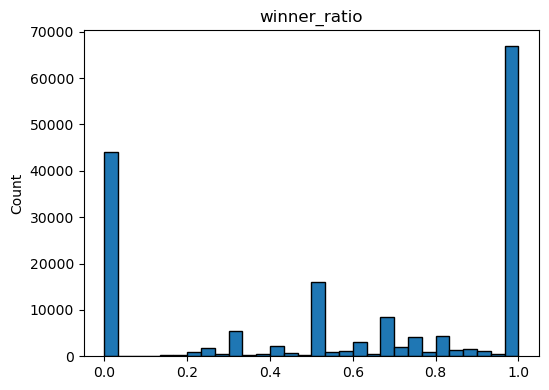

In [24]:
import matplotlib.pyplot as plt

def plot_histograms(df, num_vars, bins=30, cols=3, figsize=(15, 4)):
    n = len(num_vars)
    rows = (n + cols - 1) // cols
    fig, axes = plt.subplots(rows, cols, figsize=(figsize[0], figsize[1] * rows))
    axes = axes.flatten()
    
    for ax, col in zip(axes, num_vars):
        ax.hist(df[col].dropna(), bins=bins, edgecolor='black')
        ax.set_title(col)
        ax.set_xlabel('')
        ax.set_ylabel('Count')
    
    # remove any unused subplots
    for ax in axes[n:]:
        fig.delaxes(ax)
    
    plt.tight_layout()
    plt.show()
plot_histograms(train, ['winner_ratio'])


In [30]:
import numpy as np
import pandas as pd
from scipy.special import expit  # this is the sigmoid function

# Assume 'winner_ratio' column exists in your DataFrame
winner_ratio_raw = train['winner_ratio'].values

# 1. Log(1 + winner_ratio)
log_transformed = np.log1p(winner_ratio_raw)

# 2. Sigmoid activation
sigmoid_scaled = expit(log_transformed)

# 3. Final transformed value
log_sigmoid_product = log_transformed * sigmoid_scaled

# Store it in your DataFrame if you like
train['log_sigmoid_wr'] = log_sigmoid_product

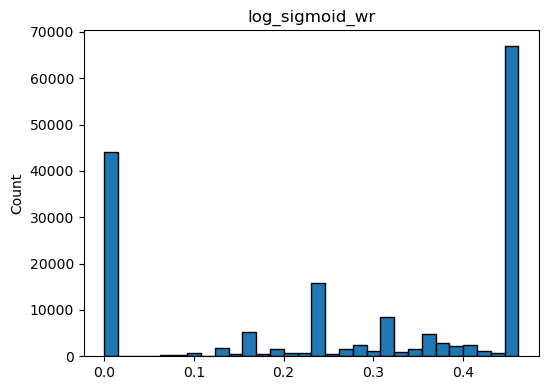

In [31]:
plot_histograms(train, ['log_sigmoid_wr'])



▶ Fold 1
Training until validation scores don't improve for 100 rounds
[100]	valid_0's l2: 0.101709
[200]	valid_0's l2: 0.100053
[300]	valid_0's l2: 0.0993385
[400]	valid_0's l2: 0.0990417
[500]	valid_0's l2: 0.0989455
[600]	valid_0's l2: 0.0989393
[700]	valid_0's l2: 0.0990002
Early stopping, best iteration is:
[614]	valid_0's l2: 0.0989367
   LGB   val MSE = 0.09893670982971413
[0]	eval-rmse:0.40461
[100]	eval-rmse:0.32344
[200]	eval-rmse:0.31974
[300]	eval-rmse:0.31781
[400]	eval-rmse:0.31670
[500]	eval-rmse:0.31593
[600]	eval-rmse:0.31542
[700]	eval-rmse:0.31504
[800]	eval-rmse:0.31477
[900]	eval-rmse:0.31462
[1000]	eval-rmse:0.31453
[1100]	eval-rmse:0.31448
[1200]	eval-rmse:0.31445
[1300]	eval-rmse:0.31444
[1386]	eval-rmse:0.31454
   XGB   val MSE = 0.09828408054861977

▶ Fold 2
Training until validation scores don't improve for 100 rounds
[100]	valid_0's l2: 0.102306
[200]	valid_0's l2: 0.1006
[300]	valid_0's l2: 0.0999119
[400]	valid_0's l2: 0.0996813
[500]	valid_0's l2: 0.0995

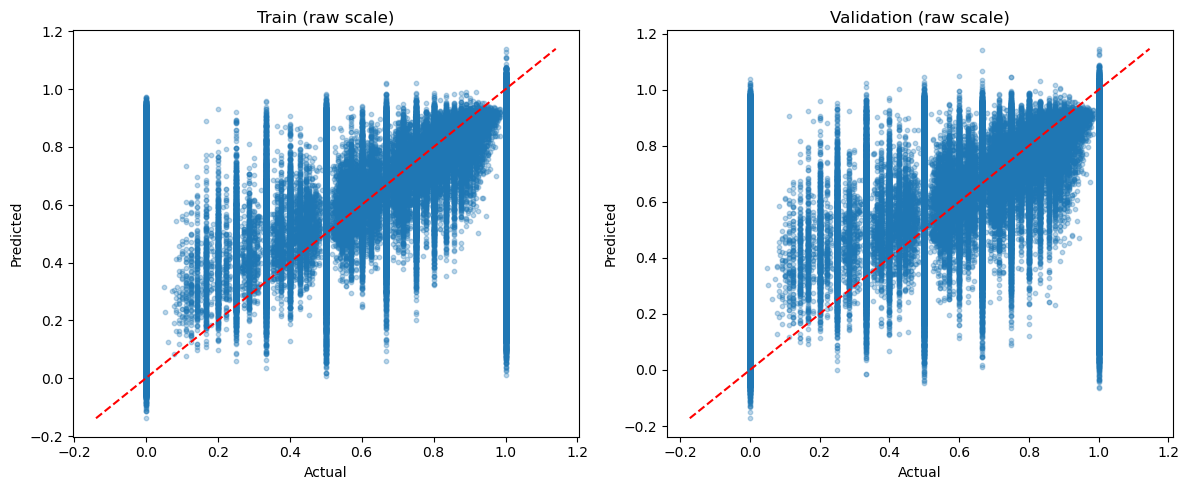

In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
import lightgbm as lgb
import xgboost as xgb

# ── 1) FEATURES & TARGET ──────────────────────────────────────────────────────
FEATURES = [
    'politician_incumbency_ratio',
    'politician_incumbency_count',
    'politician_challenger_ratio',
    'politician_open_pos_ratio',
    'politician_challenger_count',
    'politician_open_pos_count',
    'governor_contribution_ratio',
    'contribution_sum_2010_usd',
    'candidacy_count',
    'house_and_assembly_contributions_sum_2010_usd',
    'senate_contributions_sum_2010_usd',
    'senate_contribution_ratio',
    'governor_contributions_sum_2010_usd',
    'house_and_assembly_contribution_ratio',
    'politician_count',
    'candidacy_republican_count',
    'politician_republican_count',
    'contribution_republican_count',
    'contribution_count',
    'contribution_republican_sum_2010_usd'
]

X      = train[FEATURES]
y      = train["winner_ratio"]    # **raw** winner_ratio in [0,1]
X_test = test[FEATURES]

# ── 2) STORAGE FOR OOF & TEST ─────────────────────────────────────────────────
n_splits      = 5
kf            = KFold(n_splits=n_splits, shuffle=True, random_state=42)
ooe_val       = np.zeros(len(X))     # ensemble OOF preds
ooe_train_lgb = np.zeros(len(X))     # in‑fold Train preds LGB
ooe_train_xgb = np.zeros(len(X))     # in‑fold Train preds XGB
preds_lgb     = np.zeros(len(X_test))# test preds LGB
preds_xgb     = np.zeros(len(X_test))# test preds XGB

# ── 3) MODEL PARAMS ───────────────────────────────────────────────────────────
lgb_params = {
    "objective":        "regression",
    "metric":           "mse",
    "learning_rate":    0.03,
    "num_leaves":       256,
    "feature_fraction": 0.8,
    "bagging_fraction": 0.8,
    "bagging_freq":     1,
    "min_data_in_leaf": 50,
    "verbose":          -1,
    "seed":             42
}
xgb_params = {
    "objective":         "reg:squarederror",
    "eta":               0.03,
    "max_depth":         8,
    "subsample":         0.8,
    "colsample_bytree":  0.8,
    "eval_metric":       "rmse",
    "seed":              42,
    "verbosity":         0
}

# ── 4) TRAIN & COLLECT PREDICTIONS ────────────────────────────────────────────
for fold, (tr_idx, val_idx) in enumerate(kf.split(X), 1):
    print(f"\n▶ Fold {fold}")
    X_tr, X_val = X.iloc[tr_idx], X.iloc[val_idx]
    y_tr, y_val = y.iloc[tr_idx], y.iloc[val_idx]

    # -- LightGBM
    dtrain = lgb.Dataset(X_tr, label=y_tr)
    dval   = lgb.Dataset(X_val, label=y_val, reference=dtrain)
    lgb_model = lgb.train(
        params          = lgb_params,
        train_set       = dtrain,
        num_boost_round = 5000,
        valid_sets      = [dval],
        callbacks       = [
            lgb.early_stopping(stopping_rounds=100),
            lgb.log_evaluation(period=100)
        ]
    )
    it_lgb = lgb_model.best_iteration
    # store in‑fold and out‑of‑fold
    ooe_train_lgb[tr_idx] = lgb_model.predict(X_tr,  num_iteration=it_lgb)
    ooe_val[val_idx]      = lgb_model.predict(X_val,  num_iteration=it_lgb)
    preds_lgb            += lgb_model.predict(X_test, num_iteration=it_lgb) / n_splits
    print("   LGB   val MSE =", mean_squared_error(y_val, ooe_val[val_idx]))

    # -- XGBoost
    dtrain_x = xgb.DMatrix(X_tr, label=y_tr)
    dval_x   = xgb.DMatrix(X_val, label=y_val)
    xgb_model = xgb.train(
        params                = xgb_params,
        dtrain                = dtrain_x,
        num_boost_round       = 5000,
        evals                 = [(dval_x, "eval")],
        early_stopping_rounds = 100,
        verbose_eval          = 100
    )
    it_xgb = xgb_model.best_iteration
    ooe_train_xgb[tr_idx] = xgb_model.predict(dtrain_x,     iteration_range=(0, it_xgb))
    # ensemble on validation (average of two)
    ooe_val[val_idx]     += xgb_model.predict(dval_x,   iteration_range=(0, it_xgb))
    preds_xgb            += xgb_model.predict(xgb.DMatrix(X_test), iteration_range=(0, it_xgb)) / n_splits
    print("   XGB   val MSE =", mean_squared_error(y_val, ooe_val[val_idx] / 2))

# final OOF + test
ooe_val   /= 2
preds_all  = (preds_lgb + preds_xgb) / 2

print("\n▶ CV MSE Ensemble:", mean_squared_error(y, ooe_val))

# ── 5) PLOT ACTUAL vs PREDICTED ─────────────────────────────────────────────────
def plot_side_by_side(y_true, train_pred, y_true2, val_pred, label):
    fig, axes = plt.subplots(1, 2, figsize=(12,5))
    for ax, (yt, yp, title) in zip(axes, [
           (y_true, train_pred,    "Train"),
           (y_true2, val_pred,    "Validation")
    ]):
        ax.scatter(yt, yp, alpha=0.3, s=10)
        mn, mx = min(yt.min(), yp.min()), max(yt.max(), yp.max())
        ax.plot([mn,mx],[mn,mx], 'r--')
        ax.set_title(f"{title} (raw {label})")
        ax.set_xlabel("Actual")
        ax.set_ylabel("Predicted")
    plt.tight_layout()
    plt.show()

train_pred = (ooe_train_lgb + ooe_train_xgb) / 2
val_pred   = ooe_val

plot_side_by_side(y, train_pred, y, val_pred, "scale")



▶ Fold 1
Training until validation scores don't improve for 100 rounds
[200]	valid_0's l2: 32.917
[400]	valid_0's l2: 32.6475
[600]	valid_0's l2: 32.5983
Early stopping, best iteration is:
[615]	valid_0's l2: 32.5917


/opt/anaconda3/envs/env3.11/lib/python3.11/site-packages/xgboost/core.py:723: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



▶ Fold 2
Training until validation scores don't improve for 100 rounds
[200]	valid_0's l2: 33.1755
[400]	valid_0's l2: 32.9135
[600]	valid_0's l2: 32.8892
Early stopping, best iteration is:
[550]	valid_0's l2: 32.8728


/opt/anaconda3/envs/env3.11/lib/python3.11/site-packages/xgboost/core.py:723: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



▶ Fold 3
Training until validation scores don't improve for 100 rounds
[200]	valid_0's l2: 32.4011
[400]	valid_0's l2: 32.1727
[600]	valid_0's l2: 32.1621
Early stopping, best iteration is:
[517]	valid_0's l2: 32.1457


/opt/anaconda3/envs/env3.11/lib/python3.11/site-packages/xgboost/core.py:723: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



▶ Fold 4
Training until validation scores don't improve for 100 rounds
[200]	valid_0's l2: 32.5279
[400]	valid_0's l2: 32.2981
[600]	valid_0's l2: 32.2905
Early stopping, best iteration is:
[524]	valid_0's l2: 32.2709


/opt/anaconda3/envs/env3.11/lib/python3.11/site-packages/xgboost/core.py:723: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



▶ Fold 5
Training until validation scores don't improve for 100 rounds
[200]	valid_0's l2: 33.1264
[400]	valid_0's l2: 32.8093
[600]	valid_0's l2: 32.7934
Early stopping, best iteration is:
[555]	valid_0's l2: 32.7717


/opt/anaconda3/envs/env3.11/lib/python3.11/site-packages/xgboost/core.py:723: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



🧮 CV MSE (ratio space) = 0.127662


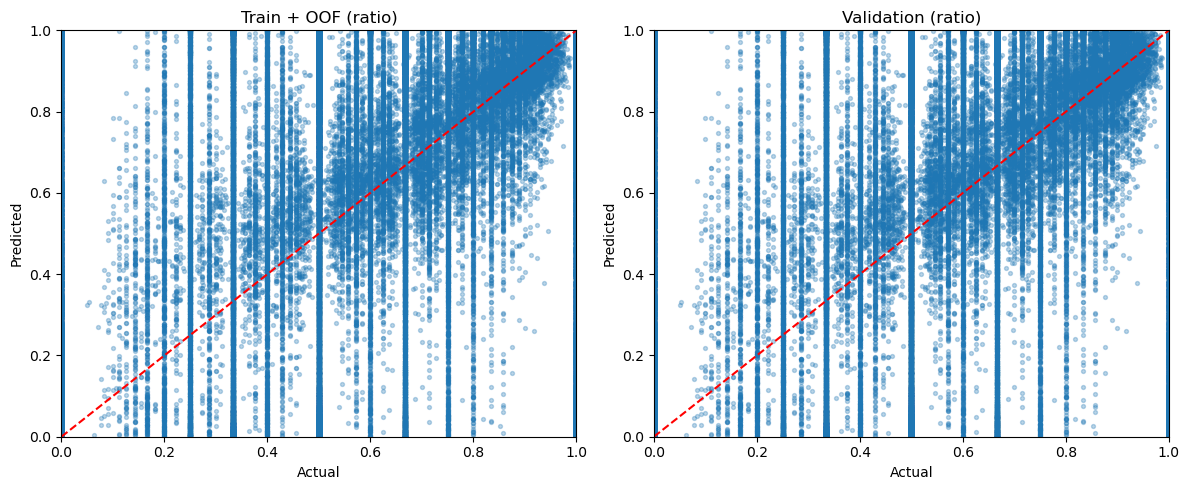

🚀 submission_logit_ensemble.csv saved


In [26]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
import lightgbm as lgb, xgboost as xgb

# ── 0)  tiny shrink + logit ──────────────────────────────────────────────────
EPS        = 1e-4                                 # keeps values in (0,1)
y_clipped  = train["winner_ratio"].clip(EPS, 1-EPS)
y_logit    = np.log(y_clipped / (1 - y_clipped))  # target for the models

# ── 1)  FEATURES  ────────────────────────────────────────────────────────────
FEATURES = [
    'politician_incumbency_ratio','politician_incumbency_count',
    'politician_challenger_ratio','politician_open_pos_ratio',
    'politician_challenger_count','politician_open_pos_count',
    'governor_contribution_ratio','contribution_sum_2010_usd',
    'candidacy_count','house_and_assembly_contributions_sum_2010_usd',
    'senate_contributions_sum_2010_usd','senate_contribution_ratio',
    'governor_contributions_sum_2010_usd','house_and_assembly_contribution_ratio',
    'politician_count','candidacy_republican_count',
    'politician_republican_count','contribution_republican_count',
    'contribution_count','contribution_republican_sum_2010_usd'
]

X       = train[FEATURES]
X_test  = test[FEATURES]

# ── 2)  CV holders ───────────────────────────────────────────────────────────
n_splits  = 5
kf        = KFold(n_splits, shuffle=True, random_state=42)

oof_logit = np.zeros(len(X))
pred_lgb  = np.zeros(len(X_test))
pred_xgb  = np.zeros(len(X_test))

# ── 3)  model params (unchanged) ─────────────────────────────────────────────
lgb_params = dict(objective="regression", metric="mse", learning_rate=0.03,
                  num_leaves=256, feature_fraction=0.8, bagging_fraction=0.8,
                  bagging_freq=1, min_data_in_leaf=50, verbose=-1, seed=42)

xgb_params = dict(objective="reg:squarederror", eta=0.03, max_depth=8,
                  subsample=0.8, colsample_bytree=0.8, eval_metric="rmse",
                  seed=42, verbosity=0)

# ── 4)  CV loop ───────────────────────────────────────────────────────────────
for fold, (tr, val) in enumerate(kf.split(X), 1):
    print(f"\n▶ Fold {fold}")
    X_tr, X_val = X.iloc[tr], X.iloc[val]
    y_tr, y_val = y_logit.iloc[tr], y_logit.iloc[val]

    # LightGBM
    dtr = lgb.Dataset(X_tr, y_tr);  dvl = lgb.Dataset(X_val, y_val, reference=dtr)
    m_lgb = lgb.train(lgb_params, dtr, 5000, [dvl],
                      callbacks=[lgb.early_stopping(100), lgb.log_evaluation(200)])
    it_lgb  = m_lgb.best_iteration
    oof_logit[val] += m_lgb.predict(X_val, num_iteration=it_lgb) / 2
    pred_lgb       += m_lgb.predict(X_test, num_iteration=it_lgb) / n_splits

    # XGBoost
    dtr_x = xgb.DMatrix(X_tr,  y_tr)
    dvl_x = xgb.DMatrix(X_val, y_val)
    m_xgb = xgb.train(xgb_params, dtr_x, 5000, [(dvl_x,'eval')],
                      early_stopping_rounds=100, verbose_eval=False)
    it_xgb = m_xgb.best_iteration
    oof_logit[val] += m_xgb.predict(dvl_x, iteration_range=(0, it_xgb)) / 2
    pred_xgb       += m_xgb.predict(xgb.DMatrix(X_test), iteration_range=(0, it_xgb)) / n_splits

# ── 5)  back‑transform to ratio space & CV score ──────────────────────────────
sigmoid   = lambda z: 1 / (1 + np.exp(-z))
oof_ratio = sigmoid(oof_logit)
test_pred = sigmoid(0.5 * (pred_lgb + pred_xgb))

cv_mse = mean_squared_error(train["winner_ratio"], oof_ratio)
print(f"\n🧮 CV MSE (ratio space) = {cv_mse:.6f}")

# ── 6)  scatter plots ─────────────────────────────────────────────────────────
def plot_pred(actual, pred, title, ax):
    ax.scatter(actual, pred, s=8, alpha=.3)
    mn,mx = 0,1
    ax.plot([mn,mx],[mn,mx],'r--')
    ax.set_xlim(mn,mx); ax.set_ylim(mn,mx)
    ax.set_xlabel("Actual"); ax.set_ylabel("Predicted"); ax.set_title(title)

fig, axs = plt.subplots(1,2, figsize=(12,5))
plot_pred(train["winner_ratio"],     oof_ratio, "Train + OOF (ratio)", axs[0])
plot_pred(train["winner_ratio"],     oof_ratio, "Validation (ratio)",   axs[1])
plt.tight_layout(); plt.show()

# ── 7)  submission ────────────────────────────────────────────────────────────
sub = pd.DataFrame({"index": test.index, "winner_ratio": np.clip(test_pred,0,1)})
sub.to_csv("submission_logit_ensemble.csv", index=False)
print("🚀 submission_logit_ensemble.csv saved")


Weight range after clipping : 2.55 → 38.62

▶ Fold 1
Training until validation scores don't improve for 100 rounds
[200]	valid_0's l2: 0.0457388
[400]	valid_0's l2: 0.0454395
[600]	valid_0's l2: 0.0453686
Early stopping, best iteration is:
[594]	valid_0's l2: 0.045362
   LGB MSE 0.10638778543170929
[0]	val-rmse:0.27593
[200]	val-rmse:0.21482
[400]	val-rmse:0.21398
[600]	val-rmse:0.21353
[800]	val-rmse:0.21337
[1000]	val-rmse:0.21329
[1074]	val-rmse:0.21327
   XGB MSE 0.10707701461091981

▶ Fold 2
Training until validation scores don't improve for 100 rounds
[200]	valid_0's l2: 0.0464647
[400]	valid_0's l2: 0.0462358
[600]	valid_0's l2: 0.0461516
Early stopping, best iteration is:
[570]	valid_0's l2: 0.0461284
   LGB MSE 0.10737114065331795
[0]	val-rmse:0.27764
[200]	val-rmse:0.21634
[400]	val-rmse:0.21573
[600]	val-rmse:0.21545
[800]	val-rmse:0.21527
[1000]	val-rmse:0.21515
[1101]	val-rmse:0.21515
   XGB MSE 0.10797506305146048

▶ Fold 3
Training until validation scores don't improve f

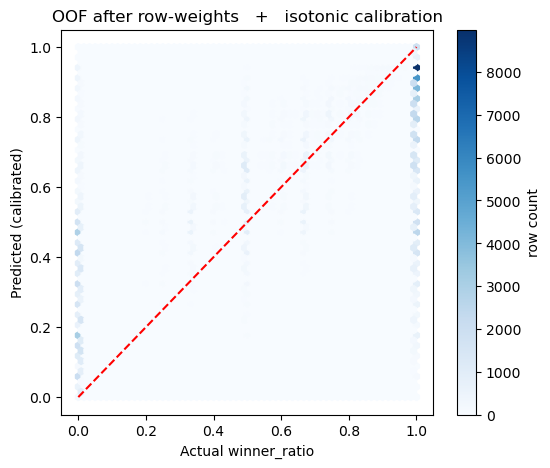


✅  submission_weighted_iso.csv  written


In [27]:
# --------------------------------------------------------------------------------
# 0 · PREP
# --------------------------------------------------------------------------------
import numpy as np, pandas as pd, matplotlib.pyplot as plt, lightgbm as lgb, xgboost as xgb
from sklearn.model_selection import KFold
from sklearn.metrics      import mean_squared_error
from sklearn.isotonic     import IsotonicRegression

# ── feature list ────────────────────────────────────────────────────────────────
FEATURES = [
    'politician_incumbency_ratio','politician_incumbency_count',
    'politician_challenger_ratio','politician_open_pos_ratio',
    'politician_challenger_count','politician_open_pos_count',
    'governor_contribution_ratio','contribution_sum_2010_usd',
    'candidacy_count','house_and_assembly_contributions_sum_2010_usd',
    'senate_contributions_sum_2010_usd','senate_contribution_ratio',
    'governor_contributions_sum_2010_usd','house_and_assembly_contribution_ratio',
    'politician_count','candidacy_republican_count','politician_republican_count',
    'contribution_republican_count','contribution_count',
    'contribution_republican_sum_2010_usd'
]

X      = train[FEATURES]
y      = train["winner_ratio"].astype("float32")        # raw ratio in [0,1]
X_test = test[FEATURES]

# --------------------------------------------------------------------------------
# 1 ·  FREQUENCY  WEIGHTS  (inverse freq, clipped at 10× median)
# --------------------------------------------------------------------------------
freq           = y.value_counts(normalize=True)
w_raw          = 1.0 / y.map(freq)          # rare ratios get larger weights
cap            = np.median(w_raw) * 10
weights        = w_raw.clip(upper=cap)      # avoid a few rows blowing up the loss
print(f"Weight range after clipping : {weights.min():.2f} → {weights.max():.2f}")

# --------------------------------------------------------------------------------
# 2 ·  MODEL PARAMS
# --------------------------------------------------------------------------------
lgb_params = {
    "objective":"regression", "metric":"mse", "learning_rate":0.03,
    "num_leaves":256, "feature_fraction":0.8, "bagging_fraction":0.8,
    "bagging_freq":1, "min_data_in_leaf":50, "verbose":-1, "seed":42
}
xgb_params = {
    "objective":"reg:squarederror", "eta":0.03, "max_depth":8,
    "subsample":0.8, "colsample_bytree":0.8, "eval_metric":"rmse",
    "seed":42, "verbosity":0
}

# --------------------------------------------------------------------------------
# 3 ·  K‑FOLD TRAINING  (OOF storage + test preds)
# --------------------------------------------------------------------------------
n_splits = 5
kf       = KFold(n_splits=n_splits, shuffle=True, random_state=42)

oof_lgb = np.zeros(len(X)); oof_xgb = np.zeros(len(X))
pred_lgb= np.zeros(len(X_test)); pred_xgb = np.zeros(len(X_test))

for fold,(tr,va) in enumerate(kf.split(X),1):
    print(f"\n▶ Fold {fold}")
    X_tr, X_va  = X.iloc[tr], X.iloc[va]
    y_tr, y_va  = y.iloc[tr], y.iloc[va]
    w_tr, w_va  = weights.iloc[tr], weights.iloc[va]

    # —— LightGBM ——
    dtr = lgb.Dataset(X_tr, y_tr, weight=w_tr)
    dva = lgb.Dataset(X_va, y_va, weight=w_va, reference=dtr)
    mdl = lgb.train(lgb_params, dtr, 5000, valid_sets=[dva],
                    callbacks=[lgb.early_stopping(100), lgb.log_evaluation(200)])
    best = mdl.best_iteration
    oof_lgb[va] += mdl.predict(X_va, num_iteration=best)
    pred_lgb    += mdl.predict(X_test, num_iteration=best) / n_splits
    print("   LGB MSE", mean_squared_error(y_va, oof_lgb[va]))

    # —— XGBoost ——
    dtr_x = xgb.DMatrix(X_tr,  y_tr, weight=w_tr)
    dva_x = xgb.DMatrix(X_va,  y_va, weight=w_va)
    mdl_x = xgb.train(xgb_params, dtr_x, 5000, evals=[(dva_x,"val")],
                      early_stopping_rounds=100, verbose_eval=200)
    best_x = mdl_x.best_iteration
    oof_xgb[va] += mdl_x.predict(dva_x, iteration_range=(0,best_x))
    pred_xgb    += mdl_x.predict(xgb.DMatrix(X_test), iteration_range=(0,best_x)) / n_splits
    print("   XGB MSE", mean_squared_error(y_va, oof_xgb[va]))

# —— blended raw prediction (equal weight) ——
oof_raw  = 0.5*(oof_lgb + oof_xgb)
test_raw = 0.5*(pred_lgb + pred_xgb)

print("\nRaw‑blend CV MSE :", mean_squared_error(y, oof_raw))

# --------------------------------------------------------------------------------
# 4 ·  ISOTONIC  CALIBRATION  (monotone 1‑D mapping)
# --------------------------------------------------------------------------------
iso = IsotonicRegression(out_of_bounds="clip")
iso.fit(oof_raw, y)                 # x = raw preds, y = truth
oof_iso  = iso.transform(oof_raw)
test_iso = iso.transform(test_raw)

print("Calibrated CV MSE :", mean_squared_error(y, oof_iso))

# --------------------------------------------------------------------------------
# 5 ·  HEXBIN  PLOT  (clean visual)
# --------------------------------------------------------------------------------
plt.figure(figsize=(6,5))
plt.hexbin(y, oof_iso, gridsize=60, cmap="Blues",
           extent=[0,1, 0,1])
plt.plot([0,1],[0,1],'r--')
plt.xlabel("Actual winner_ratio"); plt.ylabel("Predicted (calibrated)")
plt.colorbar(label="row count")
plt.title("OOF after row‑weights   +   isotonic calibration")
plt.show()

# --------------------------------------------------------------------------------
# 6 ·  SUBMISSION
# --------------------------------------------------------------------------------
submission = pd.DataFrame({"index":test.index,
                           "winner_ratio":np.clip(test_iso,0,1)})
submission.to_csv("submission_weighted_iso.csv", index=False)
print("\n✅  submission_weighted_iso.csv  written")


Training until validation scores don't improve for 100 rounds
[200]	valid_0's binary_logloss: 0.374762
Early stopping, best iteration is:
[253]	valid_0's binary_logloss: 0.374362
Fold 1 MSE = 0.15508584291274755
Training until validation scores don't improve for 100 rounds
[200]	valid_0's binary_logloss: 0.374789
Early stopping, best iteration is:
[233]	valid_0's binary_logloss: 0.37407
Fold 2 MSE = 0.15433182572406565
Training until validation scores don't improve for 100 rounds
[200]	valid_0's binary_logloss: 0.371425
Early stopping, best iteration is:
[165]	valid_0's binary_logloss: 0.371202
Fold 3 MSE = 0.15330500881864326
Training until validation scores don't improve for 100 rounds
[200]	valid_0's binary_logloss: 0.366236
Early stopping, best iteration is:
[278]	valid_0's binary_logloss: 0.365876
Fold 4 MSE = 0.15275147747988568
Training until validation scores don't improve for 100 rounds
[200]	valid_0's binary_logloss: 0.377409
Early stopping, best iteration is:
[167]	valid_0's

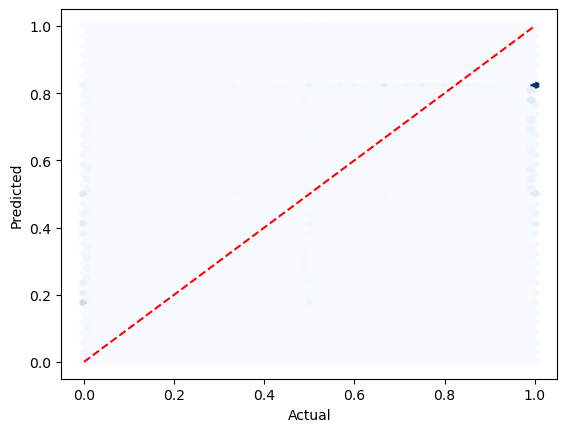


✅ submission_binomial_iso.csv written


In [28]:
# ---------------------------------------------------------------------------------
# 0 ·  libraries & data
# ---------------------------------------------------------------------------------
import numpy as np, pandas as pd, lightgbm as lgb
from sklearn.model_selection import KFold
from sklearn.isotonic      import IsotonicRegression
from sklearn.metrics       import mean_squared_error
import matplotlib.pyplot as plt


# ── feature list ────────────────────────────────────────────────────────────────
FEATURES = [
    'politician_incumbency_ratio','politician_incumbency_count',
    'politician_challenger_ratio','politician_open_pos_ratio',
    'politician_challenger_count','politician_open_pos_count',
    'governor_contribution_ratio','contribution_sum_2010_usd',
    'candidacy_count','house_and_assembly_contributions_sum_2010_usd',
    'senate_contributions_sum_2010_usd','senate_contribution_ratio',
    'governor_contributions_sum_2010_usd','house_and_assembly_contribution_ratio',
    'politician_count','candidacy_republican_count','politician_republican_count',
    'contribution_republican_count','contribution_count',
    'contribution_republican_sum_2010_usd'
]
X       = train[FEATURES]
n_trials= train["candidacy_count"].astype(int)
y_wins  = (train["winner_ratio"] * n_trials).round().astype(int)   # integer wins
X_test  = test[FEATURES]
n_trials_test = test["candidacy_count"].astype(int)                # keep for sanity

# ---------------------------------------------------------------------------------
# 1 · LightGBM with binomial likelihood  (= 'poisson' + exposure, or lambda‑trick)
#    easiest: use 'binary' objective and repeat each row n_trials times
#    but we can keep it vectorised with custom weights:
# ---------------------------------------------------------------------------------
lgb_params = dict(
    objective = "binary",            # Bernoulli log‑lik
    metric    = "binary_logloss",
    learning_rate = 0.05,
    num_leaves    = 256,
    feature_fraction = 0.8,
    bagging_fraction = 0.8,
    bagging_freq     = 1,
    min_data_in_leaf = 50,
    verbose         = -1,
    seed            = 42
)

kf          = KFold(5, shuffle=True, random_state=42)
oof_prob    = np.zeros(len(X))
test_prob   = np.zeros(len(X_test))

for fold, (tr,va) in enumerate(kf.split(X),1):
    # —— prepare labels ——
    # probit trick: each row i is repeated n_i times; instead we weight by n_i
    y_tr   = y_wins.iloc[tr] / n_trials.iloc[tr]            # ratio 0‑1
    w_tr   = n_trials.iloc[tr]                              # #trials = row weight
    y_va   = y_wins.iloc[va] / n_trials.iloc[va]
    w_va   = n_trials.iloc[va]
    
    dtr = lgb.Dataset(X.iloc[tr], label=y_tr, weight=w_tr)
    dva = lgb.Dataset(X.iloc[va], label=y_va, weight=w_va, reference=dtr)
    mdl = lgb.train(lgb_params, dtr, 5000, valid_sets=[dva],
                    callbacks=[lgb.early_stopping(100), lgb.log_evaluation(200)])
    best = mdl.best_iteration

    oof_prob[va]  = mdl.predict(X.iloc[va],  num_iteration=best)
    test_prob    += mdl.predict(X_test,      num_iteration=best) / kf.n_splits
    print(f"Fold {fold} MSE =", mean_squared_error(y_va, oof_prob[va]))

print("\nRaw binomial CV‑MSE :", mean_squared_error(train["winner_ratio"], oof_prob))

# ---------------------------------------------------------------------------------
# 2 · Isotonic calibration on top (monotone mapping)
# ---------------------------------------------------------------------------------
iso = IsotonicRegression(out_of_bounds="clip")
iso.fit(oof_prob, train["winner_ratio"])
oof_iso  = iso.transform(oof_prob)
test_iso = iso.transform(test_prob)

print("Calibrated CV‑MSE  :", mean_squared_error(train["winner_ratio"], oof_iso))

# ---------------------------------------------------------------------------------
# 3 · Quick calibration plot
# ---------------------------------------------------------------------------------
plt.hexbin(train["winner_ratio"], oof_iso, gridsize=60, cmap="Blues",
           extent=[0,1, 0,1])
plt.plot([0,1],[0,1],'r--'); plt.xlabel("Actual"); plt.ylabel("Predicted"); plt.show()

# ---------------------------------------------------------------------------------
# 4 · Submission
# ---------------------------------------------------------------------------------
sub = pd.DataFrame({"index": test.index, "winner_ratio": np.clip(test_iso,0,1)})
sub.to_csv("submission_binomial_iso.csv", index=False)
print("\n✅ submission_binomial_iso.csv written")
